## Content Salience Maps

### Imports

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

# sns.set_color_codes()
# sns.set_theme()
# sns.set_context("paper")

In [2]:
from pathlib import Path
from textwrap import wrap

import pandas as pd
import numpy as np

from info_salience.utils import savefig
from info_salience.constants import MODEL_MAP

### Plotting Utils

In [3]:
def formatFloat(fmt, val):
    ret = fmt % val
    if ret.startswith("0."):
        return ret[1:]
    elif ret.startswith("-0."):
        return "-" + ret[2:]
    elif val == 1:
        return '1'
    return ret


assert formatFloat('%.2f', 0.894) == '.89'
assert formatFloat('%.2f', 0.895) == '.90'
assert formatFloat('%.2f', 0.2) == '.20'
assert formatFloat('%.2f', 1) == '1'


def annotate_heatmap(ax, cax, data):
    for r in range(data.shape[0]):
        for c in range(data.shape[1]):
            # Get the color of the cell
            cell_value = data[r, c]
            color = cax.cmap(cax.norm(cell_value))  # Get the RGBA color for the value

            if np.isnan(cell_value):
                ax.text(c,r, '...', ha='center', va='center', color='black', fontsize=7)
                continue
            
            # Calculate the brightness (luminosity) of the color
            # Choose text color based on brightness
            brightness = 0.2126 * color[0] + 0.7152 * color[1] + 0.0722 * color[2]
            text_color = 'black' if brightness > 0.5 else 'white'
    
            cell_value = formatFloat('%.2f', cell_value)
    
            # Place the text annotation with the calculated text color
            ax.text(c, r, cell_value, ha="center", va="center", color=text_color, fontsize=5)


def set_spine_width(ax, width=0.8):
    [x.set_linewidth(0.4) for x in ax.spines.values()]


def plot_salience_maps(questions, answerable, csms, models, columns, figsize):   
    ########################################
    # Row labels
    ########################################
    xlabels = [f'Q{i+1}. {question}' for i, question in enumerate(questions)]
    xlabels_wrapped = [ '\n'.join(wrap(label, 40)) for label in xlabels]
    
    
    ########################################
    # Figure setup
    ########################################   
    fig, axes = plt.subplots(
        nrows=2,
        ncols=5,
        figsize=figsize,
        sharey='row',
        layout='constrained',
        width_ratios=[0.8, 5, 5, 5, 5],
        height_ratios=[len(xlabels),1]
    )
    
    
    ########################################
    # Plot answerability
    ########################################
    cmap = sns.color_palette("light:slategray", as_cmap=True)
    ax = axes[0][0]
    
    cax = ax.imshow(
        answerable,
        cmap=cmap,
        aspect='auto',
        vmin=0,
        vmax=1
    )
    annotate_heatmap(ax, cax, answerable)
    ax.set_yticks(range(len(xlabels_wrapped)))
    ax.set_yticklabels(xlabels_wrapped, fontsize=5)
    ax.get_xaxis().set_visible(False)
    ax.set_title('Prevalence', fontsize=6)
    
    
    ########################################
    # Plot answerability average
    ########################################
    cmap = sns.color_palette("light:slategray", as_cmap=True)
    ax = axes[1][0]
    answerable_avg = answerable.mean().reshape(1, -1)
    
    cax = ax.imshow(
        answerable_avg,
        cmap=cmap,
        aspect='auto',
        vmin=0,
        vmax=1
    )
    annotate_heatmap(ax, cax, answerable_avg)
    # ax.set_xticks([0])
    ax.set_yticks([0])
    ax.set_yticklabels(['Average'], fontsize=5)
    ax.tick_params(which='major', left=True)
    ax.get_xaxis().set_visible(False)
    
    
    ########################################
    # Plot content salience maps
    ########################################
    cmaps = ['Purples', 'Blues', 'Greens', 'Oranges']
    for i, (csm, model, cmap) in enumerate(zip(csms, models, cmaps)):
        # Top row: answerability by question
        ax = axes[0][i+1]
        data = csm
        data_avg = csm.mean(axis=0).reshape(1, -1)
        
        cax = ax.imshow(data, cmap=cmap, aspect='auto', vmin=data.min(), vmax=data.max())
        annotate_heatmap(ax, cax, data)
        
        ax.set_title(model, fontsize=6)
        ax.tick_params(which='major', left=False)
        ax.get_xaxis().set_visible(False)
    
        
        # Bottom row: average of answerability
        ax = axes[1][i+1]
        cax = ax.imshow(data_avg, cmap=cmap, aspect='auto', vmin=data.min(), vmax=data.max())
        annotate_heatmap(ax, cax, data_avg)
        ax.set_xticks(range(len(columns)))
        ax.set_xticklabels(columns, fontsize=5)
        ax.tick_params(which='major', left=False)
    
    
    for ax in axes.ravel():
        set_spine_width(ax, 1)  

    return fig

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

def plot_salience_maps(questions, answerable, csms, models, columns, figsize, max_rows=999):   
    ########################################
    # Row labels
    ########################################
    xlabels = [f'Q{i+1}. {question}' for i, question in enumerate(questions)]
    xlabels_wrapped = ['\n'.join(wrap(label, 42)) for label in xlabels]
    
    truncated_labels = xlabels_wrapped[:max_rows] + [f'... ({len(xlabels_wrapped) - max_rows} additional rows) ...'] if len(xlabels_wrapped) > max_rows else xlabels_wrapped
    
    ########################################
    # Figure setup
    ########################################   
    fig, axes = plt.subplots(
        nrows=2,
        ncols=5,
        figsize=figsize,
        sharey='row',
        layout='constrained',
        width_ratios=[0.8, 5, 5, 5, 5],
        height_ratios=[len(truncated_labels), 1]
    )
    
    ########################################
    # Function to truncate and append NaN row
    ########################################
    def truncate_and_append_nan(data):
        if data.shape[0] > max_rows:
            truncated = data[:max_rows, :]
            nan_row = np.full((1, data.shape[1]), np.nan)
            return np.vstack([truncated, nan_row])
        return data
    
    ########################################
    # Plot answerability
    ########################################
    cmap = sns.color_palette("light:slategray", as_cmap=True)
    ax = axes[0][0]
    answerable_truncated = truncate_and_append_nan(answerable)
    
    cax = ax.imshow(
        answerable_truncated,
        cmap=cmap,
        aspect='auto',
        vmin=0,
        vmax=1
    )
    annotate_heatmap(ax, cax, answerable_truncated)
    ax.set_yticks(range(len(truncated_labels)))
    ax.set_yticklabels(truncated_labels, fontsize=5)
    ax.get_xaxis().set_visible(False)
    ax.set_title('Prevalence', fontsize=6, pad=3)
    
    ########################################
    # Plot answerability average
    ########################################
    ax = axes[1][0]
    answerable_avg = answerable.mean().reshape(1, -1)
    
    cax = ax.imshow(
        answerable_avg,
        cmap=cmap,
        aspect='auto',
        vmin=0,
        vmax=1
    )
    annotate_heatmap(ax, cax, answerable_avg)
    ax.set_yticks([0])
    ax.set_yticklabels(['Average'], fontsize=5)
    ax.tick_params(which='major', left=True)
    ax.get_xaxis().set_visible(False)
    
    ########################################
    # Plot content salience maps
    ########################################
    cmaps = ['Purples', 'Blues', 'Greens', 'Oranges']
    for i, (csm, model, cmap) in enumerate(zip(csms, models, cmaps)):
        ax = axes[0][i+1]
        data_truncated = truncate_and_append_nan(csm)
        data_avg = csm.mean(axis=0).reshape(1, -1)
        
        cax = ax.imshow(data_truncated, cmap=cmap, aspect='auto', vmin=csm.min(), vmax=csm.max())
        annotate_heatmap(ax, cax, data_truncated)
        
        ax.set_title(model, fontsize=6, pad=3)
        ax.tick_params(which='major', left=False)
        ax.get_xaxis().set_visible(False)
    
        # Bottom row: average of answerability
        ax = axes[1][i+1]
        cax = ax.imshow(data_avg, cmap=cmap, aspect='auto', vmin=csm.min(), vmax=csm.max())
        annotate_heatmap(ax, cax, data_avg)
        ax.set_xticks(range(len(columns)))
        ax.set_xticklabels(columns, fontsize=5)
        ax.tick_params(which='major', left=False)
    
    for ax in axes.ravel():
        set_spine_width(ax, 1)  
    
    return fig


### Data loading

In [6]:
def load_questions(questions_path):
    """
    Loads questions as DataFrame.

    Returns
    -------
    df_questions: pd.DataFrame
        index: cluster_id
        columns: ['question', 'group_id']
    """
    df_questions = pd.read_json(questions_path)
    df_questions = df_questions.rename({'centroid': 'question'}, axis=1)
    df_questions = df_questions[['cluster_id', 'group_id', 'group_name', 'question']]
    assert df_questions['group_id'].nunique() == len(df_questions)
    assert df_questions['cluster_id'].nunique() == len(df_questions)
    return df_questions


def load_answerability(reference_answer_path):
    """
    Calculates reference answer rate.

    Returns
    -------
    df_answerability: pd.DataFrame
        index: cluster_id
        columns: ['answerability']
    """
    
    df_answers = pd.read_json(reference_answer_path)
    df_answers['answerable'] = df_answers['reference_answer'] != 'no answer'
    df_answerability = df_answers.groupby('cluster_id')['answerable'].mean()
    df_answerability = df_answerability.to_frame().reset_index()
    return df_answerability


def average_entailment_by_question(json_glob):
    """
    Arguments
    ---------
    json_glob: str
        Path to answer fact entailments. When this resolves to multiple files, all of them are loaded and the result is averaged.
        
    """
    
    cols = ['summary_10w_nli_pred', 'summary_20w_nli_pred', 'summary_50w_nli_pred', 'summary_100w_nli_pred', 'summary_200w_nli_pred']
    
    dfs = []
    base_path = Path(json_glob).parent
    glob = Path(json_glob).name
    for json_file in base_path.glob(glob):
        df = pd.read_json(json_file)
        df = df.groupby(['doc_id','cluster_id'])[cols].mean()
        dfs.append(df)
    return pd.concat(dfs).groupby(level=1).mean()


def prepare_data(questions_path, reference_answer_path, rating_paths, question_order=None):
    df_questions = load_questions(questions_path)
    df_answerability = load_answerability(reference_answer_path)
    df_questions = pd.merge(df_questions, df_answerability, on='cluster_id', validate='one_to_one')
    df_questions = df_questions.sort_values('group_id')

    dfs = []
    models = []
    for rating_path in rating_paths:
        rating_path = Path(rating_path) 
        models.append(rating_path.parent.parent.name)
        df = average_entailment_by_question(rating_path)
        df = pd.merge(df_questions, df, on='cluster_id', validate='one_to_one')
        
        if question_order:
            df['custom_order'] = df['question'].apply(lambda q: question_order[q])
            df = df.sort_values('custom_order')
        dfs.append(df)

    return dfs, models

In [7]:
dfs, models = prepare_data(
    questions_path='../output/pubmed-sample/discord_questions.json',
    reference_answer_path='../output/pubmed-sample/discord_answers.json',
    rating_paths=[
        '../output/pubmed-sample/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-*.json',
        '../output/pubmed-sample/Meta-Llama-3.1-70B-Instruct/discord-qa-nli/temperature0.3-*.json',
    ]
)

print(models[0])
display(dfs[0])

gpt-4o-2024-08-06


,cluster_id,group_id,group_name,question,answerable,summary_10w_nli_pred,summary_20w_nli_pred,summary_50w_nli_pred,summary_100w_nli_pred,summary_200w_nli_pred
0,1,1,Topic,What is the main focus of the study?,1.000,0.276303,0.503467,0.773658,0.893454,0.948820
1,10,2,Population,Which patient population is the study concerne...,0.970,0.211521,0.340444,0.486260,0.698311,0.879068
2,9,3,Population -- Condition,What condition is being addressed in the study?,1.000,0.370790,0.520930,0.653330,0.791388,0.884472
3,18,4,Population -- demographics,What is the participant demographic or charact...,0.940,0.126322,0.184318,0.294838,0.552781,0.740954
4,36,5,Intervention,What was the main intervention used in the study?,0.965,0.128114,0.273737,0.561070,0.717539,0.868873
5,31,6,Intervention -- benefits,What are the significant benefits of the inter...,0.940,0.175362,0.323463,0.545954,0.698790,0.867464
6,6,7,Intervention -- biomarkers,What are the specific biological markers influ...,0.395,0.056016,0.136049,0.322160,0.547917,0.763324
7,34,8,Comparators,What specific treatments were compared in the ...,0.930,0.131862,0.241869,0.475410,0.705203,0.888560
8,23,9,Outcomes,What specific metrics or outcomes were measured?,0.910,0.049951,0.127873,0.349987,0.541655,0.820389
9,28,10,Outcomes -- Secondary,What are secondary outcomes noted in the study?,0.800,0.055236,0.146896,0.343186,0.512292,0.762514


## Draw heatmaps

### astro-ph

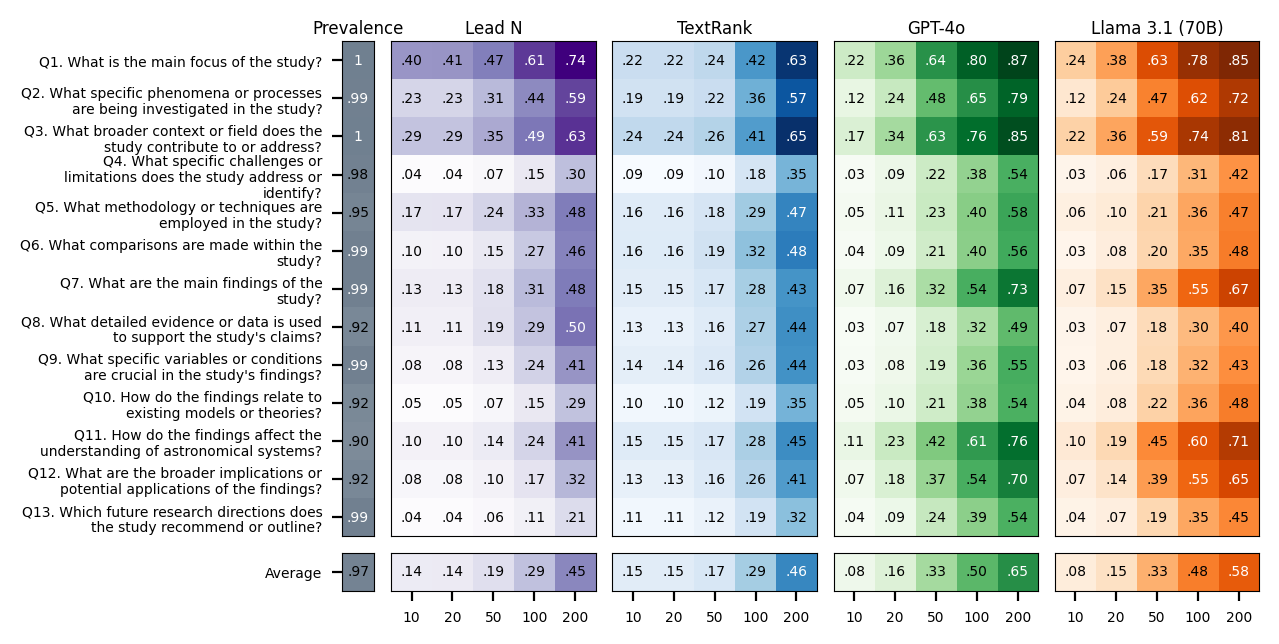

In [8]:
dfs, models = prepare_data(
    questions_path='../output/astro-ph/discord_questions.json',
    reference_answer_path='../output/astro-ph/discord_answers.json',
    rating_paths=[
        '../output/astro-ph/lead_n/discord-qa-nli/output.json',
        '../output/astro-ph/textrank/discord-qa-nli/output.json',
        '../output/astro-ph/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-*.json',
        '../output/astro-ph/Meta-Llama-3.1-70B-Instruct/discord-qa-nli/temperature0.3-*.json',
    ]
)

cols = ['summary_10w_nli_pred', 'summary_20w_nli_pred', 'summary_50w_nli_pred', 'summary_100w_nli_pred', 'summary_200w_nli_pred']
column_labels = ['10', '20', '50', '100', '200']

questions = dfs[0]['question']
answerable = dfs[0]['answerable'].values.reshape(-1, 1)
csms = [df[cols].values for df in dfs]
models = [MODEL_MAP[model] for model in models]

width = 6.28
height = 0.222 * (len(questions)+1)
figsize = (width, height)

fig = plot_salience_maps(questions, answerable, csms, models, column_labels, figsize)
savefig(fig, 'salience-astro-ph', path='../output/figures-paper/', formats=['pdf'])

### cs-cl

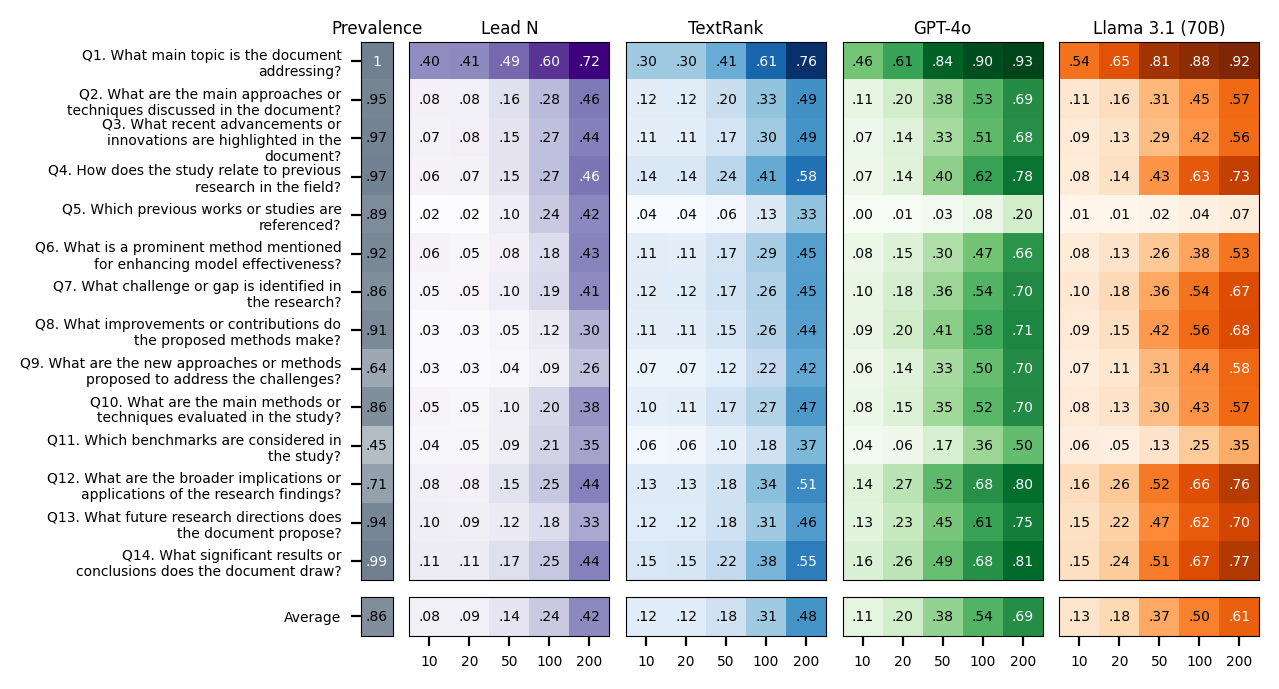

In [9]:
dfs, models = prepare_data(
    questions_path='../output/cs-cl/discord_questions.json',
    reference_answer_path='../output/cs-cl/discord_answers.json',
    rating_paths=[
        '../output/cs-cl/lead_n/discord-qa-nli/output.json',
        '../output/cs-cl/textrank/discord-qa-nli/output.json',
        '../output/cs-cl/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-*.json',
        '../output/cs-cl/Meta-Llama-3.1-70B-Instruct/discord-qa-nli/temperature0.3-*.json',
    ]
)

cols = ['summary_10w_nli_pred', 'summary_20w_nli_pred', 'summary_50w_nli_pred', 'summary_100w_nli_pred', 'summary_200w_nli_pred']
column_labels = ['10', '20', '50', '100', '200']

questions = dfs[0]['question']
answerable = dfs[0]['answerable'].values.reshape(-1, 1)
csms = [df[cols].values for df in dfs]
models = [MODEL_MAP[model] for model in models]

width = 6.28
height = 0.222 * (len(questions)+1)
figsize = (width, height)
fig = plot_salience_maps(questions, answerable, csms, models, column_labels, figsize)
savefig(fig, 'salience-cs-cl', path='../output/figures-paper/', formats=['pdf'])

### pubmed-sample

reorder and truncate

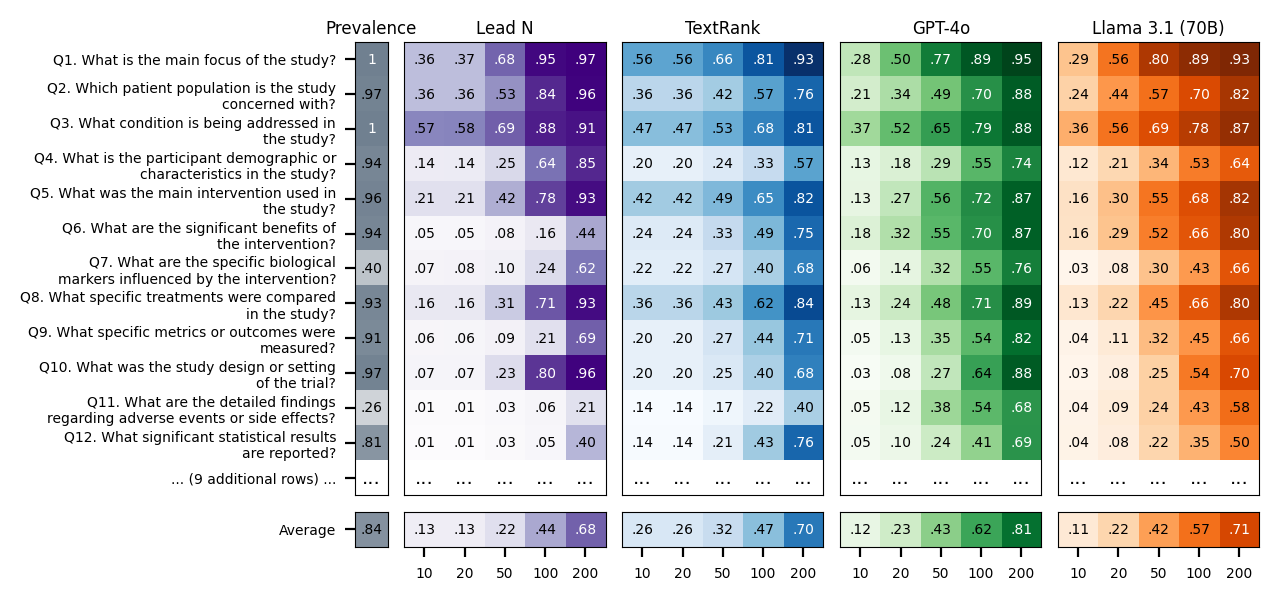

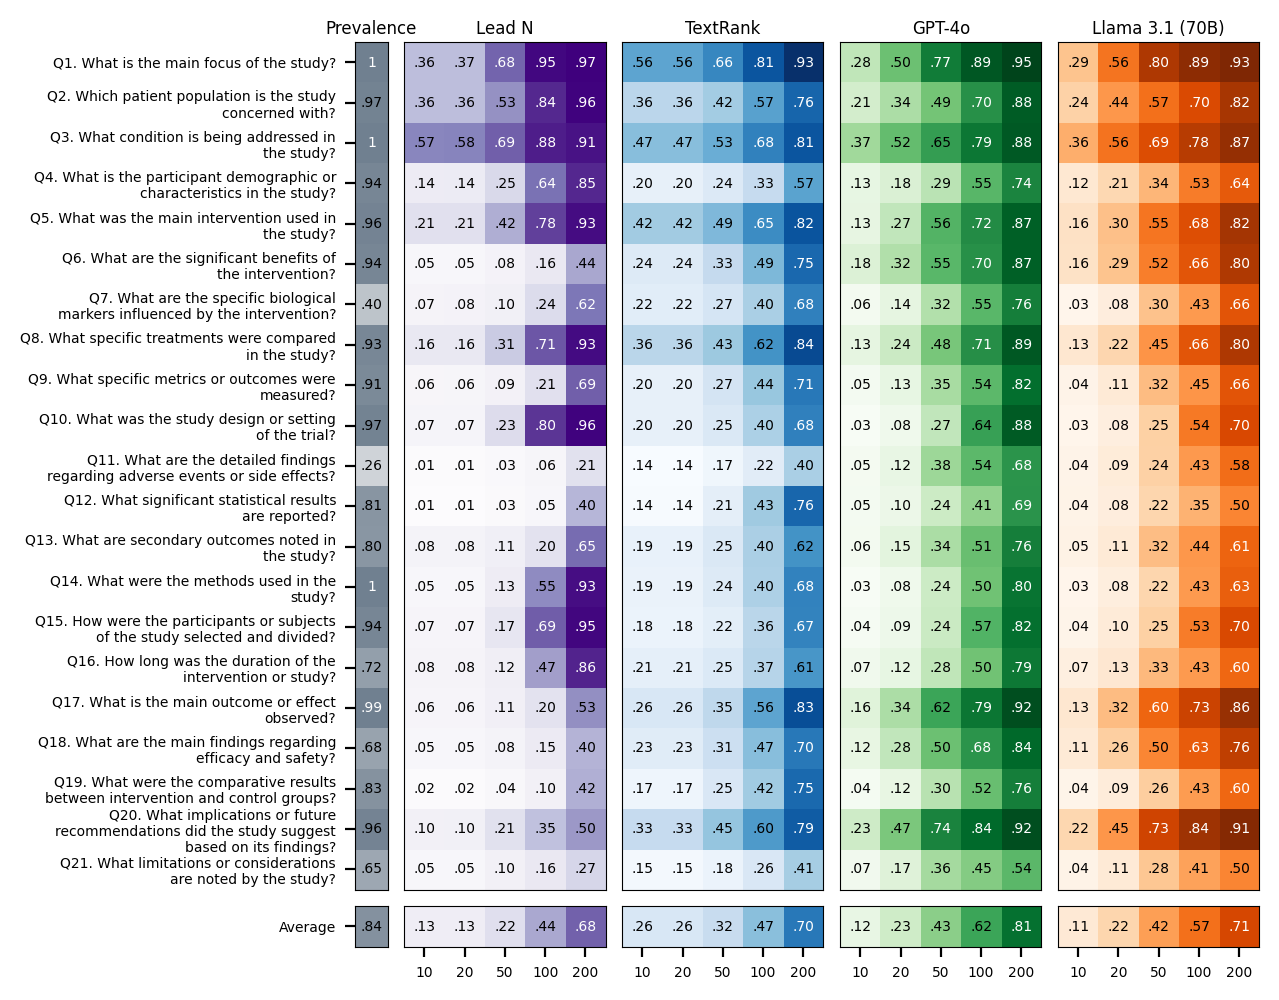

In [11]:
pubmed_question_order = [
    'What is the main focus of the study?',
    'Which patient population is the study concerned with?',
    'What condition is being addressed in the study?',
    'What is the participant demographic or characteristics in the study?',
    'What was the main intervention used in the study?',
    'What are the significant benefits of the intervention?',
    'What are the specific biological markers influenced by the intervention?',
    'What specific treatments were compared in the study?',
    'What specific metrics or outcomes were measured?',
    'What was the study design or setting of the trial?',
    'What are the detailed findings regarding adverse events or side effects?',
    'What significant statistical results are reported?',
    # cutoff
    'What are secondary outcomes noted in the study?',
    'What were the methods used in the study?',
    'How were the participants or subjects of the study selected and divided?',
    'How long was the duration of the intervention or study?',
    'What is the main outcome or effect observed?',
    'What are the main findings regarding efficacy and safety?',
    'What were the comparative results between intervention and control groups?',
    'What implications or future recommendations did the study suggest based on its findings?',
    'What limitations or considerations are noted by the study?'
]
pubmed_question_order = {q: i for i, q in enumerate(pubmed_question_order)}

dfs, models = prepare_data(
    questions_path='../output/pubmed-sample/discord_questions.json',
    reference_answer_path='../output/pubmed-sample/discord_answers.json',
    rating_paths=[
        '../output/pubmed-sample/lead_n/discord-qa-nli/output.json',
        '../output/pubmed-sample/textrank/discord-qa-nli/output.json',
        '../output/pubmed-sample/gpt-4o-2024-08-06/discord-qa-nli/temperature0.3-*.json',
        '../output/pubmed-sample/Meta-Llama-3.1-70B-Instruct/discord-qa-nli/temperature0.3-*.json',
    ],
    question_order=pubmed_question_order
)

cols = ['summary_10w_nli_pred', 'summary_20w_nli_pred', 'summary_50w_nli_pred', 'summary_100w_nli_pred', 'summary_200w_nli_pred']
column_labels = ['10', '20', '50', '100', '200']

questions = dfs[0]['question']
answerable = dfs[0]['answerable'].values.reshape(-1, 1)
csms = [df[cols].values for df in dfs]
models = [MODEL_MAP[model] for model in models]

max_rows = 12
width = 6.28
height = 0.222 * (max_rows+1)
figsize = (width, height)
fig = plot_salience_maps(questions, answerable, csms, models, column_labels, figsize, max_rows)
savefig(fig, 'salience-pubmed-sample-split', path='../output/figures-paper/', formats=['pdf'])


width = 6.28
height = 0.222 * (len(questions)+1)
figsize = (width, height)
fig = plot_salience_maps(questions, answerable, csms, models, column_labels, figsize)
savefig(fig, 'salience-pubmed-sample', path='../output/figures-paper/', formats=['pdf'])

### qmsum

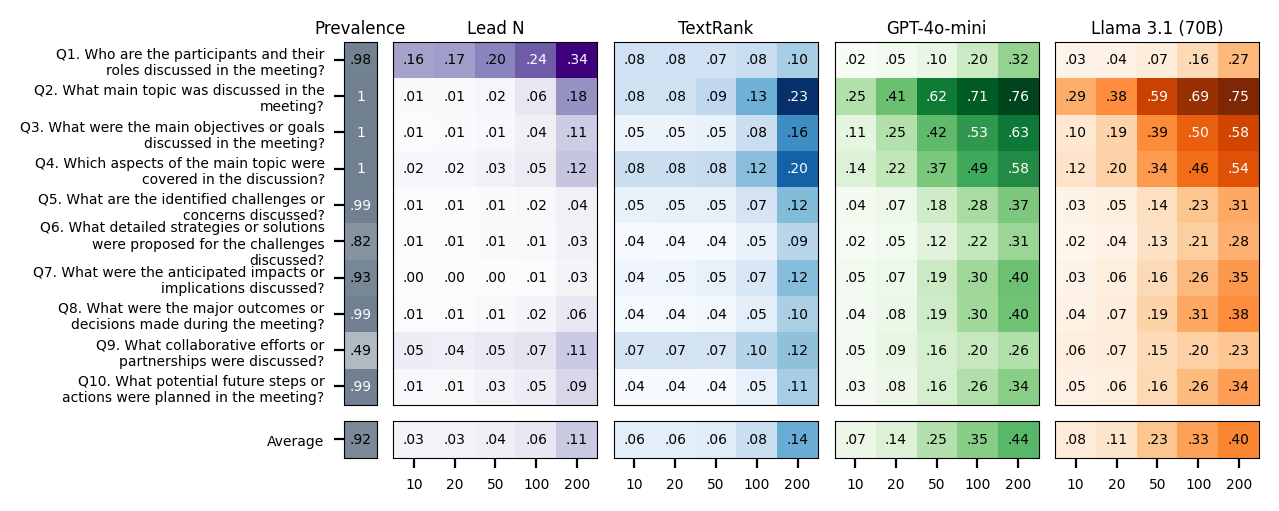

In [12]:
dfs, models = prepare_data(
    questions_path='../output/qmsum-generic/discord_questions.json',
    reference_answer_path='../output/qmsum-generic/discord_answers.json',
    rating_paths=[
        '../output/qmsum-generic/lead_n/discord-qa-nli/output.json',
        '../output/qmsum-generic/textrank/discord-qa-nli/output.json',
        '../output/qmsum-generic/gpt-4o-mini-2024-07-18/discord-qa-nli/temperature0.3-*.json',
        '../output/qmsum-generic/Meta-Llama-3.1-70B-Instruct/discord-qa-nli/temperature0.3-*.json',
    ]
)

cols = ['summary_10w_nli_pred', 'summary_20w_nli_pred', 'summary_50w_nli_pred', 'summary_100w_nli_pred', 'summary_200w_nli_pred']
column_labels = ['10', '20', '50', '100', '200']

questions = dfs[0]['question']
answerable = dfs[0]['answerable'].values.reshape(-1, 1)
csms = [df[cols].values for df in dfs]
models = [MODEL_MAP[model] for model in models]

width = 6.28
height = 0.222 * (len(questions)+1)
figsize = (width, height)
fig = plot_salience_maps(questions, answerable, csms, models, column_labels, figsize)
savefig(fig, 'salience-qmsum', path='../output/figures-paper/', formats=['pdf'])